# **ML Lifecycle**
### This notebook combines the analysis, cleaning, preprocessing, visualization, pipeline generation and model training process into functions that can be used for different datasets

#### Dataset features must include - "processed_text", "priority", "urgency"

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report


In [3]:
df = pd.read_csv('../csv/hf_combined.csv')
df.sample(3)

,label,processed_text,priority,urgency,type,queue
4842,1.0,Order Processing Delays Due to Database Locking,medium,not_urgent,NaN,NaN
6017,0.0,Web3 provider intermittently disconnecting und...,low,not_urgent,NaN,NaN
4447,2.0,API does not respect Accept-Language headers a...,high,urgent,NaN,NaN


## Analysis

In [9]:
def analysis(df):
    print(f'Shape : {df.shape}\n')
    print(f'Columns : {df.columns}\n')
    print(f"Sample: \n{df.sample(3)}\n")
    print(f"Null values: \n{df.isnull().sum()}\n")

analysis(df)

Shape : (8649, 6)

Columns : Index(['label', 'processed_text', 'priority', 'urgency', 'type', 'queue'], dtype='object')

Sample: 
      label                                     processed_text priority  \
6663    0.0  Occasional minor disruptions in non-critical n...      low   
4234    2.0  Delayed block time impacts application perform...     high   
1617    2.0  Immediate action required for performance degr...     high   

         urgency type queue  
6663  not_urgent  NaN   NaN  
4234      urgent  NaN   NaN  
1617      urgent  NaN   NaN  

Null values: 
label             1564
processed_text       0
priority             0
urgency              0
type              7085
queue             7085
dtype: int64



## Cleaning

In [11]:
def clean_data(df):
    df = df[['processed_text', 'priority', 'urgency']]
    df = df.rename(columns={'processed_text': 'text'})
    return df 

df = clean_data(df)
df.sample(3)

,text,priority,urgency
2575,CSS Fails to Load on Home Page Leading to Styl...,medium,not_urgent
3385,Persistent Volume Claims Stuck in Pending State,medium,not_urgent
7520,Frequent Printer Issues. Dear Tech Online Stor...,medium,not_urgent


## Visualization - using TF-IDF Vectorizer

In [13]:
def word_importance_chart(ax, df, title):
    tdidf_vectorizer = TfidfVectorizer(lowercase=True, stop_words='english')
    tdidf_matrix = tdidf_vectorizer.fit_transform(df['text'])
    
    
    feature_names = tdidf_vectorizer.get_feature_names_out()
    word_scores = zip(feature_names, tdidf_matrix.sum(axis=0).tolist()[0])

    top_words = sorted(word_scores, key=lambda x: x[1], reverse=True)[:10]
    
    keywords, frequencies = zip(*top_words)
    
    ax.barh(keywords, frequencies)
    ax.set_title(title)
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Keyword')
    ax.invert_yaxis()

In [18]:
def distribution_chart(ax, df, column, title, category):
    sns.countplot(data=df, x=column, ax=ax)
    ax.set_title(title)

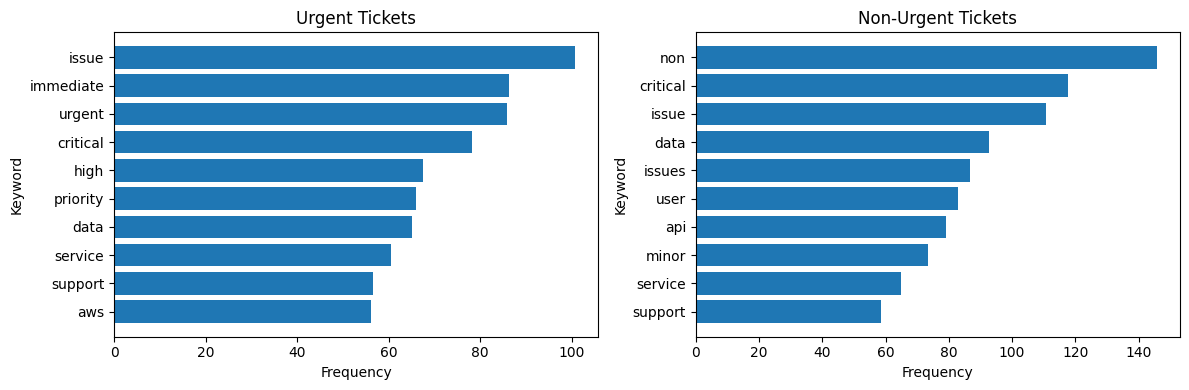

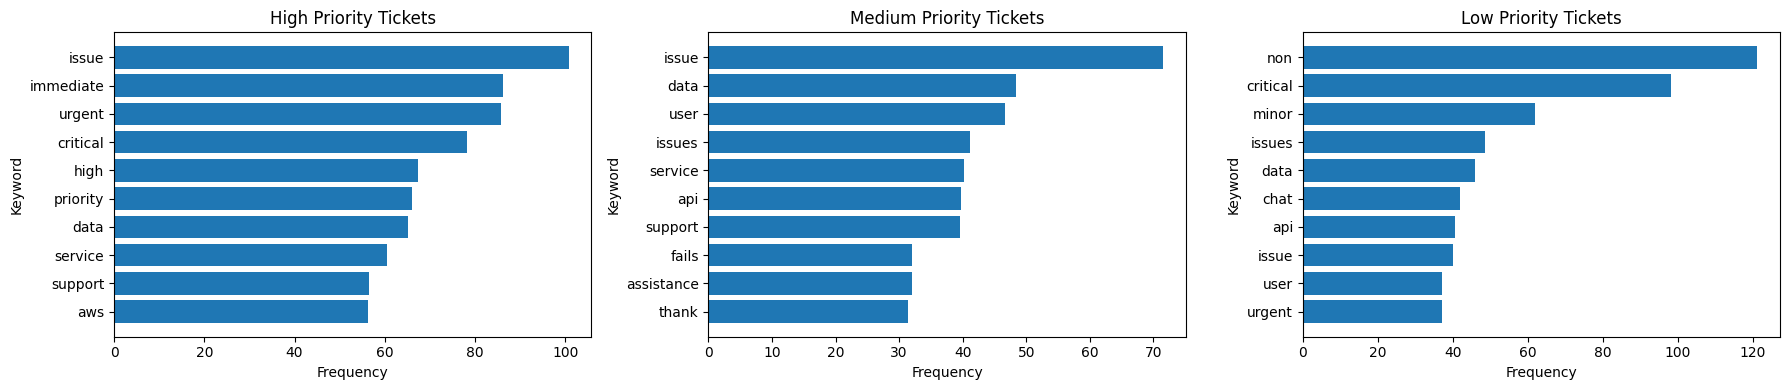

In [17]:
urgent_df = df[df['urgency'] == 'urgent']
non_urgent_df = df[df['urgency'] == 'not_urgent']

high_priority_df = df[df['priority'] == 'high']
medium_priority_df = df[df['priority'] == 'medium']
low_priority_df = df[df['priority'] == 'low']

# Urgent/Non-Urgent Tickets
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
word_importance_chart(axs[0], urgent_df, 'Urgent Tickets')
word_importance_chart(axs[1], non_urgent_df, 'Non-Urgent Tickets')
plt.tight_layout()

# Priority Tickets
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
word_importance_chart(axs[0], high_priority_df, 'High Priority Tickets')
word_importance_chart(axs[1], medium_priority_df, 'Medium Priority Tickets')
word_importance_chart(axs[2], low_priority_df, 'Low Priority Tickets')
plt.tight_layout()


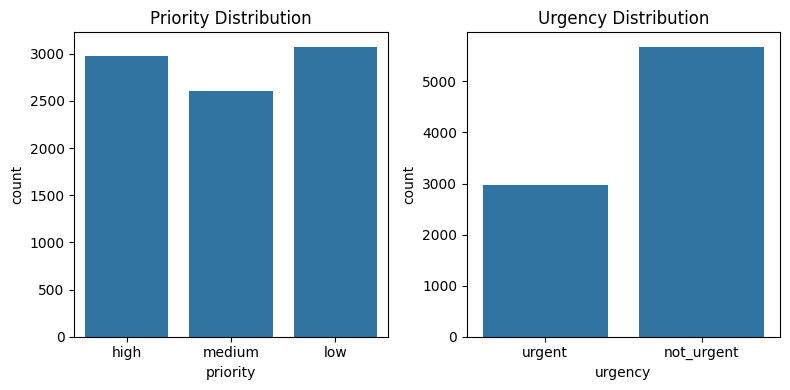

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
distribution_chart(axs[0], df, 'priority', 'Priority Distribution', 'priority')
distribution_chart(axs[1], df, 'urgency', 'Urgency Distribution', 'urgency')
plt.tight_layout()

## Train-Test Split 

In [23]:
def get_train_test_data(df, y_column):
    X = df[['text']]
    y = df[y_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test

In [24]:
X_train, X_test, y_train, y_test = get_train_test_data(df, 'priority')

X_train shape: (6919, 1)
X_test shape: (1730, 1)


## Model Training - using Pipeline

In [30]:
# Building the TF-IDF transformer and model pipeline
text_transformer = Pipeline([
    ('tfidf', TfidfVectorizer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('text_tfidf', text_transformer, 'text')
    ],
)

In [37]:
# Training the models
def train_model(model, X_train, y_train):
    pipeline =Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    print(f"Classification Report: \n{classification_report(y_test, y_pred)}")
    return pipeline

In [38]:
# Logisitic Regression
pipeline_logreg = train_model(
    LogisticRegression(random_state=42, max_iter=1000), 
    X_train, 
    y_train
)

Classification Report: 
              precision    recall  f1-score   support

        high       0.80      0.79      0.80       564
         low       0.74      0.80      0.77       618
      medium       0.62      0.58      0.60       548

    accuracy                           0.73      1730
   macro avg       0.72      0.72      0.72      1730
weighted avg       0.73      0.73      0.73      1730



In [39]:
# Support Vector Machine
pipeline_svm = train_model(
    SVC(random_state=42), 
    X_train, 
    y_train
)

Classification Report: 
              precision    recall  f1-score   support

        high       0.87      0.78      0.82       564
         low       0.73      0.83      0.78       618
      medium       0.65      0.62      0.64       548

    accuracy                           0.75      1730
   macro avg       0.75      0.74      0.75      1730
weighted avg       0.75      0.75      0.75      1730



## Testing with example texts

In [42]:
# Example of prediction
example_text = pd.DataFrame([
   'This is an urgent issue',
    'I need help with my account right now without delay',
    'I have a question about my account',
    'I cannot access my account. Please help me',
    'I am unable to access my account. I have tried resetting my password but it is not working. I need help urgently',
    "Query regarding my account. Please help me",
    "The server is down. Please fix it as soon as possible",
    "System Issue. Need help before the end of the day",
    "Jira tickets need to be updated. Please do it as soon as possible. no hurry",
    "Not Critical. Please ensure system is up and running without any issues before the end of the day.",
    ],
    columns=['text'])

print(f"Logistic Regression Prediction: {pipeline_logreg.predict(example_text)}")
print(f"SVM Prediction: {pipeline_svm.predict(example_text)}")


Logistic Regression Prediction: ['high' 'high' 'medium' 'medium' 'medium' 'medium' 'medium' 'high'
 'medium' 'low']
SVM Prediction: ['high' 'low' 'medium' 'medium' 'medium' 'medium' 'medium' 'medium' 'low'
 'low']
